# XGBoost
XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting algorithm.
http://xgboost.readthedocs.org/en/latest/parameter.html#general-parameters
https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example/XGBoost%20models.ipynb

in R
https://www.analyticsvidhya.com/blog/2016/01/xgboost-algorithm-easy-steps/

<b>XGBoost (eXtreme Gradient Boosting)</b> is an advanced implementation of gradient boosting algorithm.
https://xgboost.readthedocs.io/en/latest/tutorials/model.html


In [ ]:
#!pip install xgboost

In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

C:\Users\dave_\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\dave_\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [6]:
df.shape

(768, 9)

In [4]:
y='Outcome' #dependent variable

Before proceeding further, lets define a function which will help us create XGBoost models and perform cross-validation.<br>
<br> The function will do the following: <br>
1. fit the model <br>
2. determine training accuracy<br>
3. determine training AUC<br>
4. determine testing AUC<br>
5. perform CV is performCV is True<br>
6. plot Feature Importance if printFeatureImportance is True<br>

In [5]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Outcome'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Outcome'], 
                                                    cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Outcome'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Outcome'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" %  \
               (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
        
    #Print Feature Importance
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## XGBoost Parameters
https://xgboost.readthedocs.io/en/latest/parameter.html
The overall parameters have been divided into 3 categories by XGBoost authors:

General Parameters: Guide the overall functioning
Booster Parameters: Guide the individual booster (tree/regression) at each step
Learning Task Parameters: Guide the optimization performed
I will give analogies to GBM here and highly recommend to read this article to learn from the very basics.

General Parameters
These define the overall functionality of XGBoost.

booster [default=gbtree]
Select the type of model to run at each iteration. It has 2 options:
gbtree: tree-based models
gblinear: linear models
silent [default=0]:
Silent mode is activated is set to 1, i.e. no running messages will be printed.
It’s generally good to keep it 0 as the messages might help in understanding the model.
nthread [default to maximum number of threads available if not set]
This is used for parallel processing and number of cores in the system should be entered
If you wish to run on all cores, value should not be entered and algorithm will detect automatically
There are 2 more parameters which are set automatically by XGBoost and you need not worry about them. Lets move on to Booster parameters.

 

Booster Parameters
Though there are 2 types of boosters, I’ll consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used.

eta [default=0.3]
Analogous to learning rate in GBM
Makes the model more robust by shrinking the weights on each step
Typical final values to be used: 0.01-0.2
min_child_weight [default=1]
Defines the minimum sum of weights of all observations required in a child.
This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
Too high values can lead to under-fitting hence, it should be tuned using CV.
max_depth [default=6]
The maximum depth of a tree, same as GBM.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.
Typical values: 3-10
max_leaf_nodes
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
If this is defined, GBM will ignore max_depth.
gamma [default=0]
A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
max_delta_step [default=0]
In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
This is generally not used but you can explore further if you wish.
subsample [default=1]
Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
Typical values: 0.5-1
colsample_bytree [default=1]
Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
Typical values: 0.5-1
colsample_bylevel [default=1]
Denotes the subsample ratio of columns for each split, in each level.
I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so.
lambda [default=1]
L2 regularization term on weights (analogous to Ridge regression)
This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.
alpha [default=0]
L1 regularization term on weight (analogous to Lasso regression)
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
scale_pos_weight [default=1]
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
 

Learning Task Parameters
These parameters are used to define the optimization objective the metric to be calculated at each step.

objective [default=reg:linear]
This defines the loss function to be minimized. Mostly used values are:
binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
eval_metric [ default according to objective ]
The metric to be used for validation data.
The default values are rmse for regression and error for classification.
Typical values are:
rmse – root mean square error
mae – mean absolute error
logloss – negative log-likelihood
error – Binary classification error rate (0.5 threshold)
merror – Multiclass classification error rate
mlogloss – Multiclass logloss
auc: Area under the curve
seed [default=0]
The random number seed.
Can be used for generating reproducible results and also for parameter tuning.



## Step 1 Find the number of estimators for a high learning rate
Please note that all the above are just initial estimates and will be tuned later. 
Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv 
function of xgboost. The function defined above will do it for us.


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7927247 | Std - 0.02976924 | Min - 0.7624074 | Max - 0.8458491


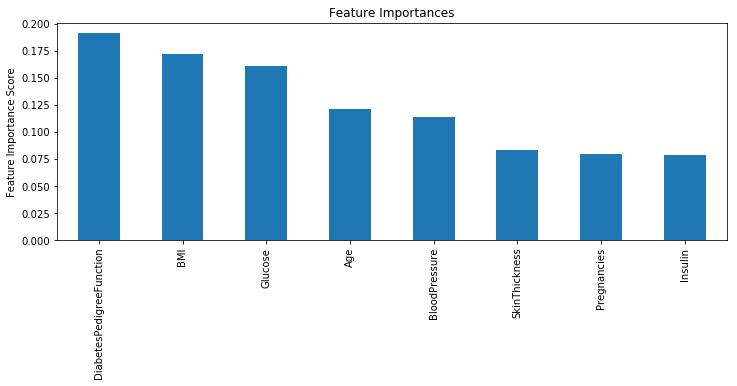

In [9]:
predictors = df.columns.values[:8]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, df, predictors)

In [10]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':list(range(3,10,2)),
    'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df[predictors],df['Outcome'])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [11]:

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.81794, std: 0.03594, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.81568, std: 0.03327, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.81898, std: 0.02897, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.81651, std: 0.03287, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.80710, std: 0.03295, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.80880, std: 0.03280, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.80816, std: 0.03264, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.80662, std: 0.03047, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.81251, std: 0.02693, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.80687, std: 0.03349, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.80812, std: 0.03152, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.80784, std: 0.03327, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 5

Here, we have run 12 combinations with wider intervals between values. The ideal values are <b>3 for max_depth</b> and <b>5 for min_child_weight</b>. Lets go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [14]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[2,3,4],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=3,
                                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(df[predictors],df['Outcome'])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [2, 3, 4], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [16]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.82973, std: 0.03282, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.83114, std: 0.03069, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.83041, std: 0.02918, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: 0.81984, std: 0.03201, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.81898, std: 0.02897, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.81792, std: 0.03340, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.80770, std: 0.03405, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.81073, std: 0.03220, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.81441, std: 0.02989, params: {'max_depth': 4, 'min_child_weight': 6}],
 {'max_depth': 2, 'min_child_weight': 5},
 0.8311355695317959)

Here, we get the optimum values as <b> 2 for max_depth</b> and <b>5 for min_child_weight</b>. Note that as the model performance increases, it becomes exponentially difficult to achieve even marginal gains in performance. You would have noticed that here we got 5 as optimum value for min_child_weight but we haven’t tried values more than 5. We can do that as follow:

In [27]:
param_test2b = {
    'min_child_weight':[5,6,7,8,9,10]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=2,
                                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(df[predictors],df['Outcome'])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=5, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [28]:
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

([mean: 0.83114, std: 0.03069, params: {'min_child_weight': 5},
  mean: 0.83041, std: 0.02918, params: {'min_child_weight': 6},
  mean: 0.83318, std: 0.03046, params: {'min_child_weight': 7},
  mean: 0.83138, std: 0.03050, params: {'min_child_weight': 8},
  mean: 0.83283, std: 0.03252, params: {'min_child_weight': 9},
  mean: 0.83061, std: 0.03323, params: {'min_child_weight': 10}],
 {'min_child_weight': 7},
 0.833178895877009)

Now, we see that min_child_weight=7 is optimum value
## Step 3: Tune gamma
Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. You can go into more precise values as.

In [29]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=2,
                                        min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(df[predictors],df['Outcome'])
    

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=7, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [30]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83318, std: 0.03046, params: {'gamma': 0.0},
  mean: 0.83318, std: 0.03003, params: {'gamma': 0.1},
  mean: 0.83162, std: 0.03173, params: {'gamma': 0.2},
  mean: 0.83121, std: 0.03155, params: {'gamma': 0.3},
  mean: 0.83154, std: 0.03172, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.833178895877009)

This shows that our original value of gamma, i.e. <b>0 is the optimum one</b>. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.


Model Report
Accuracy : 0.832
AUC Score (Train): 0.909858
CV Score : Mean - 0.8331789 | Std - 0.03045636 | Min - 0.7896296 | Max - 0.8811321


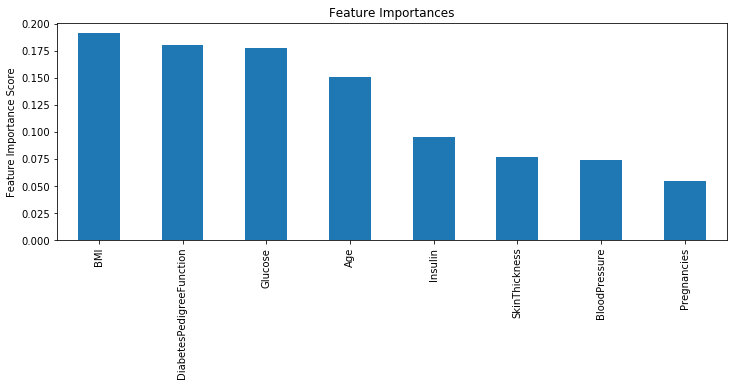

In [47]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=140,
 max_depth=2,
 min_child_weight=7,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, df, predictors)

Here, we can see the improvement in score. So the final parameters are:

max_depth: 2
min_child_weight: 7
gamma: 0


## Step 4: Tune subsample and colsample_bytree
The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.
 

In [32]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(df[predictors],df['Outcome'])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83172, std: 0.03111, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.83438, std: 0.02857, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.83479, std: 0.03280, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.83599, std: 0.02928, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.83028, std: 0.03257, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.83206, std: 0.03060, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.83449, std: 0.03451, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.83515, std: 0.03375, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.83055, std: 0.03273, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.83066, std: 0.03056, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.83318, std: 0.03046, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.83260, std: 0.03128, params: {'colsample_bytree': 0.8, 'subsample'

so the best parameters are
{'colsample_bytree': 0.6, 'subsample': 0.9},
 0.8359860237596086)
 Will try to tune this parameters further with 0.05 step
 

In [34]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,100,5)],
 'colsample_bytree':[i/100.0 for i in range(20,70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(df[predictors],df['Outcome'])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.83164, std: 0.02609, params: {'colsample_bytree': 0.2, 'subsample': 0.75},
  mean: 0.82956, std: 0.02663, params: {'colsample_bytree': 0.2, 'subsample': 0.8},
  mean: 0.83213, std: 0.02473, params: {'colsample_bytree': 0.2, 'subsample': 0.85},
  mean: 0.83126, std: 0.02396, params: {'colsample_bytree': 0.2, 'subsample': 0.9},
  mean: 0.82939, std: 0.02569, params: {'colsample_bytree': 0.2, 'subsample': 0.95},
  mean: 0.83308, std: 0.02902, params: {'colsample_bytree': 0.25, 'subsample': 0.75},
  mean: 0.83268, std: 0.02841, params: {'colsample_bytree': 0.25, 'subsample': 0.8},
  mean: 0.83592, std: 0.02728, params: {'colsample_bytree': 0.25, 'subsample': 0.85},
  mean: 0.83366, std: 0.02966, params: {'colsample_bytree': 0.25, 'subsample': 0.9},
  mean: 0.83577, std: 0.02975, params: {'colsample_bytree': 0.25, 'subsample': 0.95},
  mean: 0.83308, std: 0.02902, params: {'colsample_bytree': 0.3, 'subsample': 0.75},
  mean: 0.83268, std: 0.02841, params: {'colsample_bytree': 0.3,

so, best parameters changed to
{'colsample_bytree': 0.4, 'subsample': 0.8},
 0.8381355695317959)
 
 Try <b>regularization</b>:
 
Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [36]:
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.4,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(df[predictors],df['Outcome'])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.83814, std: 0.02851, params: {'reg_alpha': 1e-05},
  mean: 0.83884, std: 0.02842, params: {'reg_alpha': 0.01},
  mean: 0.83945, std: 0.02790, params: {'reg_alpha': 0.1},
  mean: 0.83728, std: 0.02959, params: {'reg_alpha': 1},
  mean: 0.71652, std: 0.02326, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.8394535290006988)

tune reg_alpha a bit more
We can see that the CV score is less than the previous case. But the values tried are very widespread, we should try values closer to the optimum here (0.1) to see if we get something better.

In [40]:
param_test7 = {
    'reg_alpha':[0.090, 0.095, 0.1, 0.15, 1]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.4,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(df[predictors],df['Outcome'])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.83888, std: 0.02826, params: {'reg_alpha': 0.09},
  mean: 0.83951, std: 0.02819, params: {'reg_alpha': 0.095},
  mean: 0.83945, std: 0.02790, params: {'reg_alpha': 0.1},
  mean: 0.83855, std: 0.02864, params: {'reg_alpha': 0.15},
  mean: 0.83728, std: 0.02959, params: {'reg_alpha': 1}],
 {'reg_alpha': 0.095},
 0.8395115303983228)

We got a better CV. Now we can apply this regularization in the model and look at the impact:


Model Report
Accuracy : 0.8177
AUC Score (Train): 0.904284
CV Score : Mean - 0.8395115 | Std - 0.0281896 | Min - 0.8024074 | Max - 0.8839623


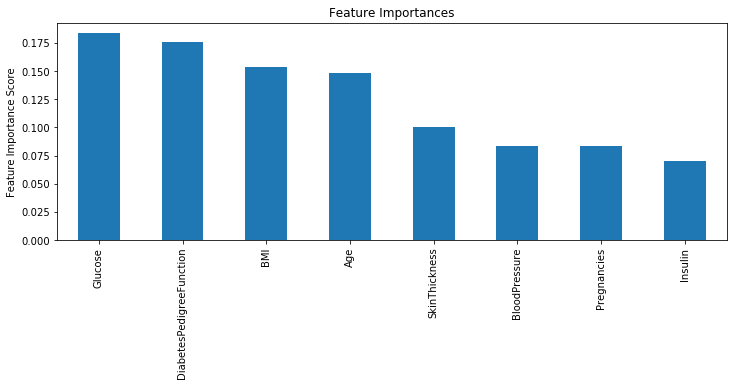

In [48]:
xgb3 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=140,
    max_depth=2,
    min_child_weight=7,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.4,
    reg_alpha=0.095,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb3, df, predictors)

Again we can see slight improvement in the score.
## Step 6: Reducing Learning Rate
Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.


Model Report
Accuracy : 0.7799
AUC Score (Train): 0.869019
CV Score : Mean - 0.8314836 | Std - 0.03296974 | Min - 0.7862963 | Max - 0.8886792


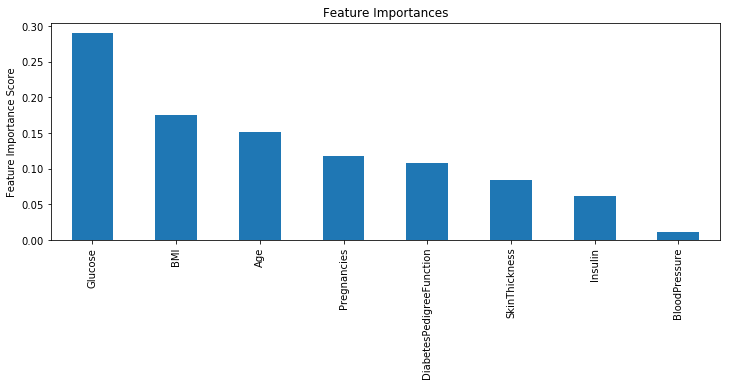

In [49]:
xgb4 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=140,
    max_depth=2,
    min_child_weight=7,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.4,
    reg_alpha=0.095,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb4, df, predictors)

Now we can see a significant boost in performance and the effect of parameter tuning is clearer.

2 key thoughts:

It is difficult to get a very big leap in performance by just using parameter tuning or slightly better models. The max score for GBM was 0.8373592 while XGBoost gave 0.8395115. This is a decent improvement but not something very substantial.
<br>
A significant jump can be obtained by other methods like feature engineering, creating ensemble of models, stacking, etc